# Extreme Value Statistics in strongly clustered environments

This notebook serves to demonstrate how to use the code for the paper by Jespersen, Carnall, and Lovell, 2025

```Explaining ultra-massive quiescent galaxies at $3 < z < 5$ in the context of their environments```

We will discuss

- [1. Introduction and Background](#1.-Introduction-and-Background) 
- [2. Breaking down the method](#2.-Breaking-down-the-method)
- [3. Putting it all together](#-3.-Putthing-it-all-together)

In [3]:
## before getting started you should run this code block, it will run while you read the introduction
!pip install -r requirements.txt

  Attempting uninstall: cosmic-variance
    Found existing installation: cosmic-variance 0.1.5
    Uninstalling cosmic-variance-0.1.5:
      Successfully uninstalled cosmic-variance-0.1.5


## 1. Introduction and Background

The code aims to provide a way to analyze the expected mass of extreme galaxies, **if** we have some sense of their **environments**. This has become important especially since the launch of the JWST telescope, which has revealed **two** classes of galaxies that have deeply challenged our understanding of early galaxy formation.

The first class is _ultra-high-redshift_ galaxies, meaning galaxies at z>10, like the amazing JADES-GS-z14-0 galaxy shown below.

<div style="text-align: center;">
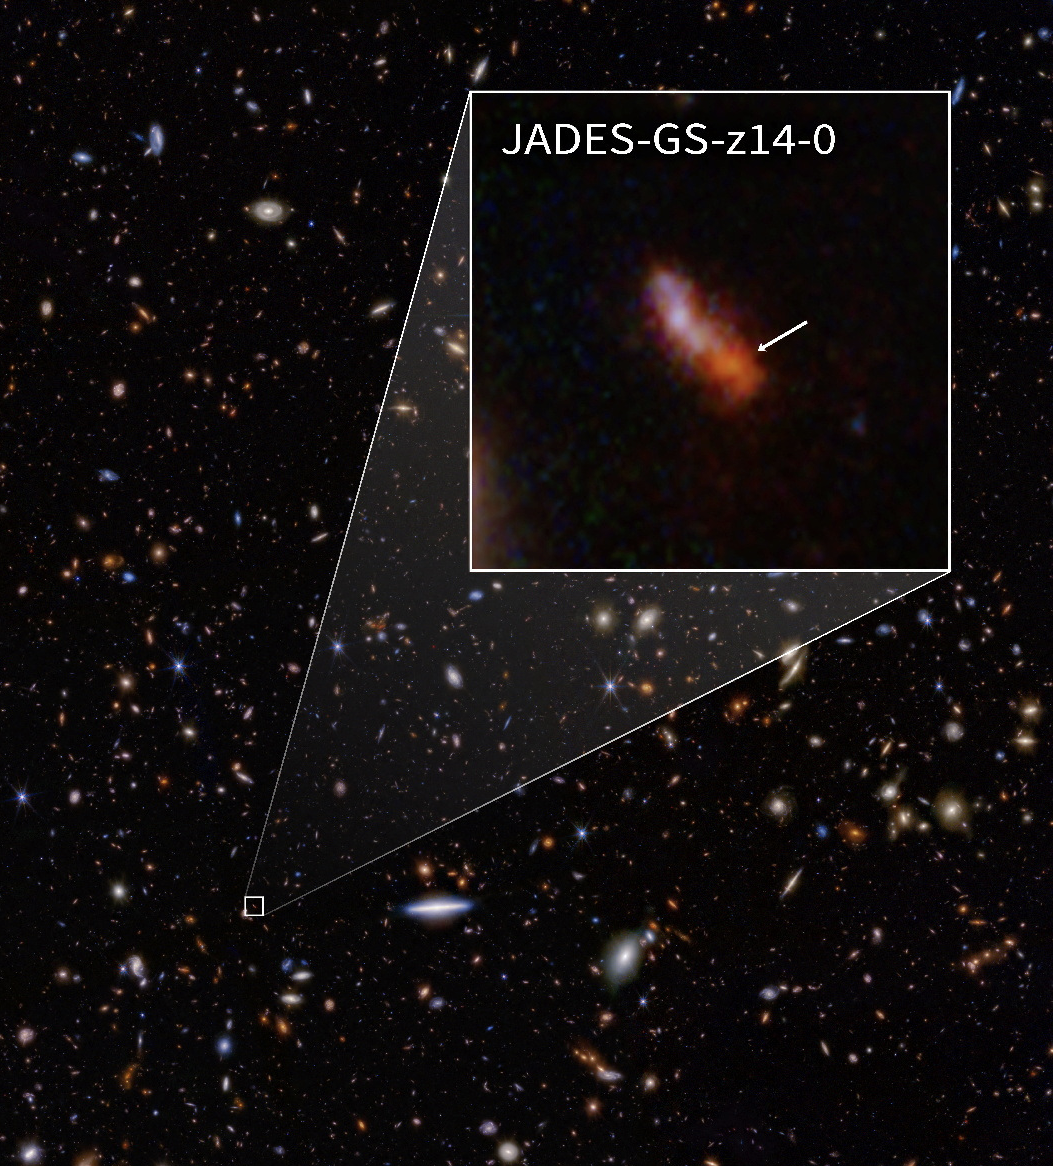
</div>

 <br>

Because these galaxies were so unexpected, they were at first hailed as _universe-breakers_, but quickly a method called [Extreme Value Statistics (EVS)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518.2511L/abstract) was developed to statistically quantify the tension between our models and observations by calculating the distribution over the possible **mass of the most massive galaxy in a given survey**. However, in [Jespersen et al. 2025](https://ui.adsabs.harvard.edu/abs/2025ApJ...982...23J/abstract) we quickly showed that the fact that we do not know the **environment** of these galaxies actually significantly changes the calculations. That is because galaxies are **not randomly distributed in space**, they actually **cluster** quite strongly. Clustering get's stronger and stronger as we go to higher redshift, higher masses, and look on smaller and smaller scales, so for _JWST_, which was designed to look at the highest redshift, most massive, galaxies, in small fields of view, this is really important!

Clustering gives rise to something usually known as _cosmic variance_ (a really cool name), which quantifies the field-to-field variation _in excess of Poisson noise_ in the galaxy number counts. It is worth noting that it is a physical, not just statistical, variance, since the clustering is a real, physical effect.

You can see how it works in the below plot, where we simulate a galaxy field with varying degrees of clustering. You should be able to easily see how the galaxies in the left-most panel cluster strongly. If we now choose a random subfield (choosing a subfield is like choosing some random part of the sky to observe), we see that the clustering leaves many of the fields almost **empty**, which means that the tail of the probability distribution for the mass of the most massive galaxy in a given field goes towards lower values!

<div style="text-align: center;">
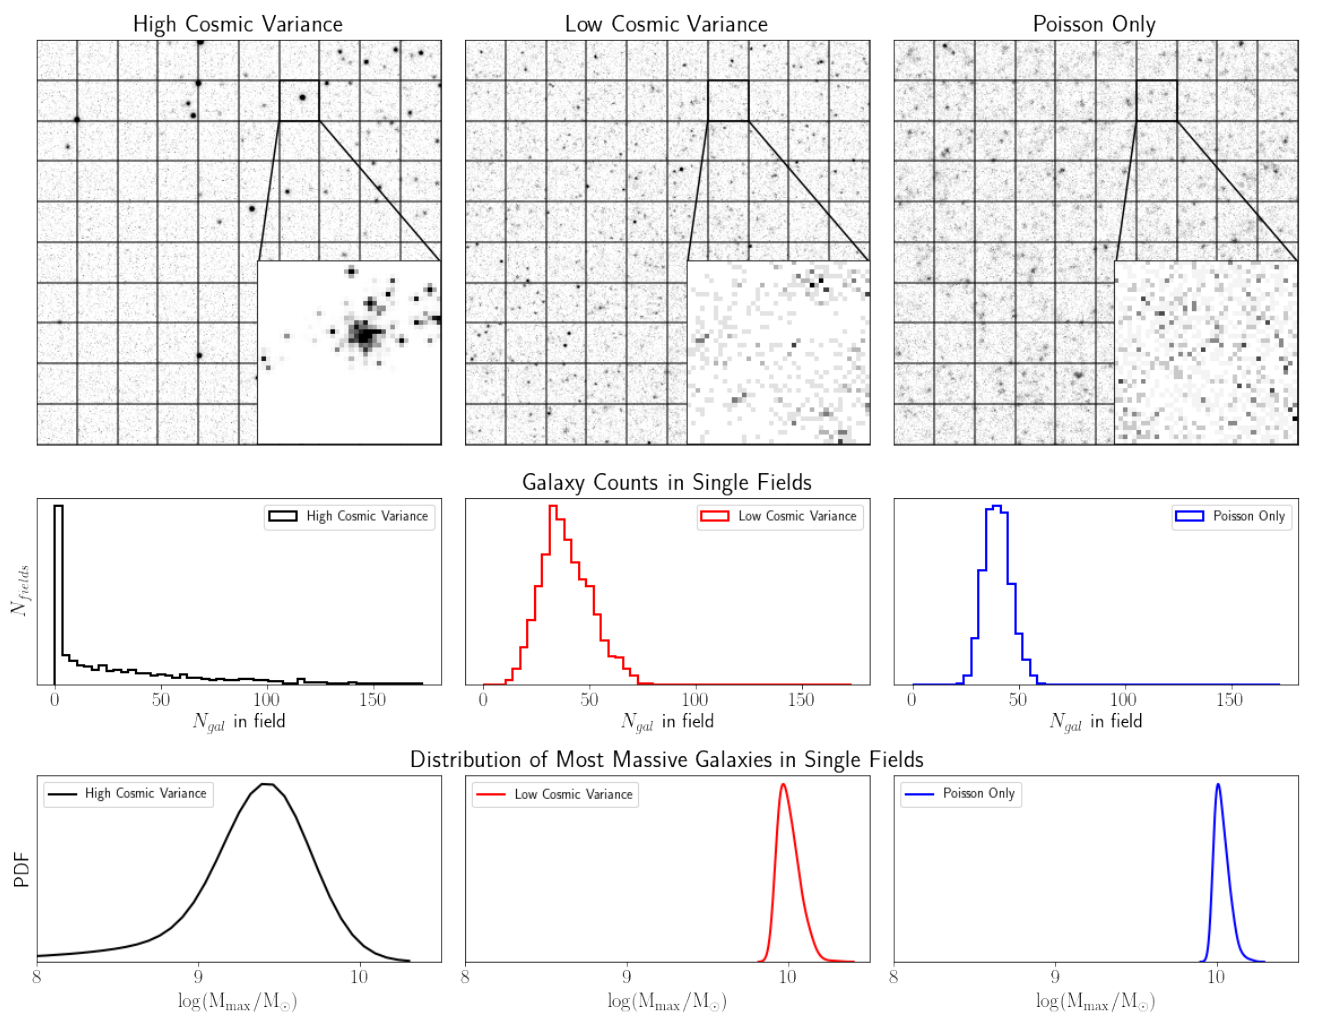
</div>

 <br>

This essentially corresponds to _marginalizing out_ the dependence on environment, because we just repeat the usual EVS calculation across different environments. Normal EVS simply assumes that all galaxies exist in the **mean** environment in the universe, an incorrect assumption.
<br>
#### However...

What if we could know what kind of environment our galaxies inhabit **before** doing the calculation? Well, this **can** the case for the _second class_ of problematic galaxies, _ultra-massive quiescent galaxies at intermediate redshifts_. So these are galaxies that fulfill three requirements

- They are found at redshifts above 3 (so when the Universe was less than ~2 billions years old)
- They are extremely massive ($M_{*}>10^{11}M_{\odot}$)
- They are **quiescent**, meaning that they stopped forming stars a long time (many hundreds of millions of years) ago

The third point is especially important, because it means that we can infer that each galaxy has been **as massive as it is now for a long time**! You can see why this gives us trouble below, where you can see the inferred stellar mass history in blue (dotted_, with the prediction from normal EVS in grey.


<div style="text-align: center;">
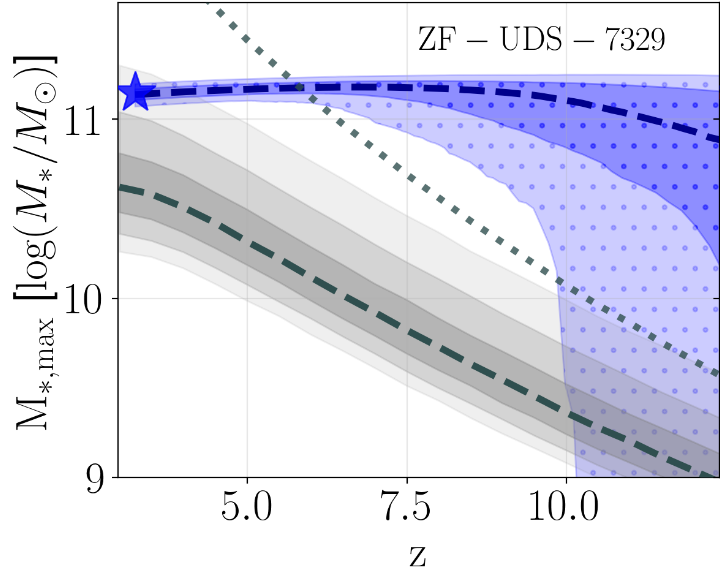
</div>

 <br>

It is clear that while the galaxy is extreme at the redshift where it is observed (blue star), the big tension comes from the fact that we know that it has been at least that massive for at least a billion years. This galaxy was found in a survey called [EXCELS](https://ui.adsabs.harvard.edu/abs/2024MNRAS.534..325C/abstract), where we also see that this galaxy isn't just special due to its' extremely early mass - it is also sitting in the middle of 63 galaxies in what we call a **proto-cluster**. If you run the code-block below, you can see its environment!

In [1]:
from IPython.display import HTML

HTML("""
<video width="1080" height="540" autoplay muted>
  <source src="graphics/zoom_tour_lowz.mp4" type="video/mp4">
</video>
""")

#### so here, we DO know the environment!

That means that we can change our approach from __marginalizing__ out our lack of knowledge of the environment to instead __conditioning__ on it!

#### To quickly spoil the surprise, this let's us accomodate galaxies that are almost an order of magnitude heavier!

Here you can see the contours for the same galaxies, with our, environment-dependent, predictions in red.
<div style="text-align: center;">
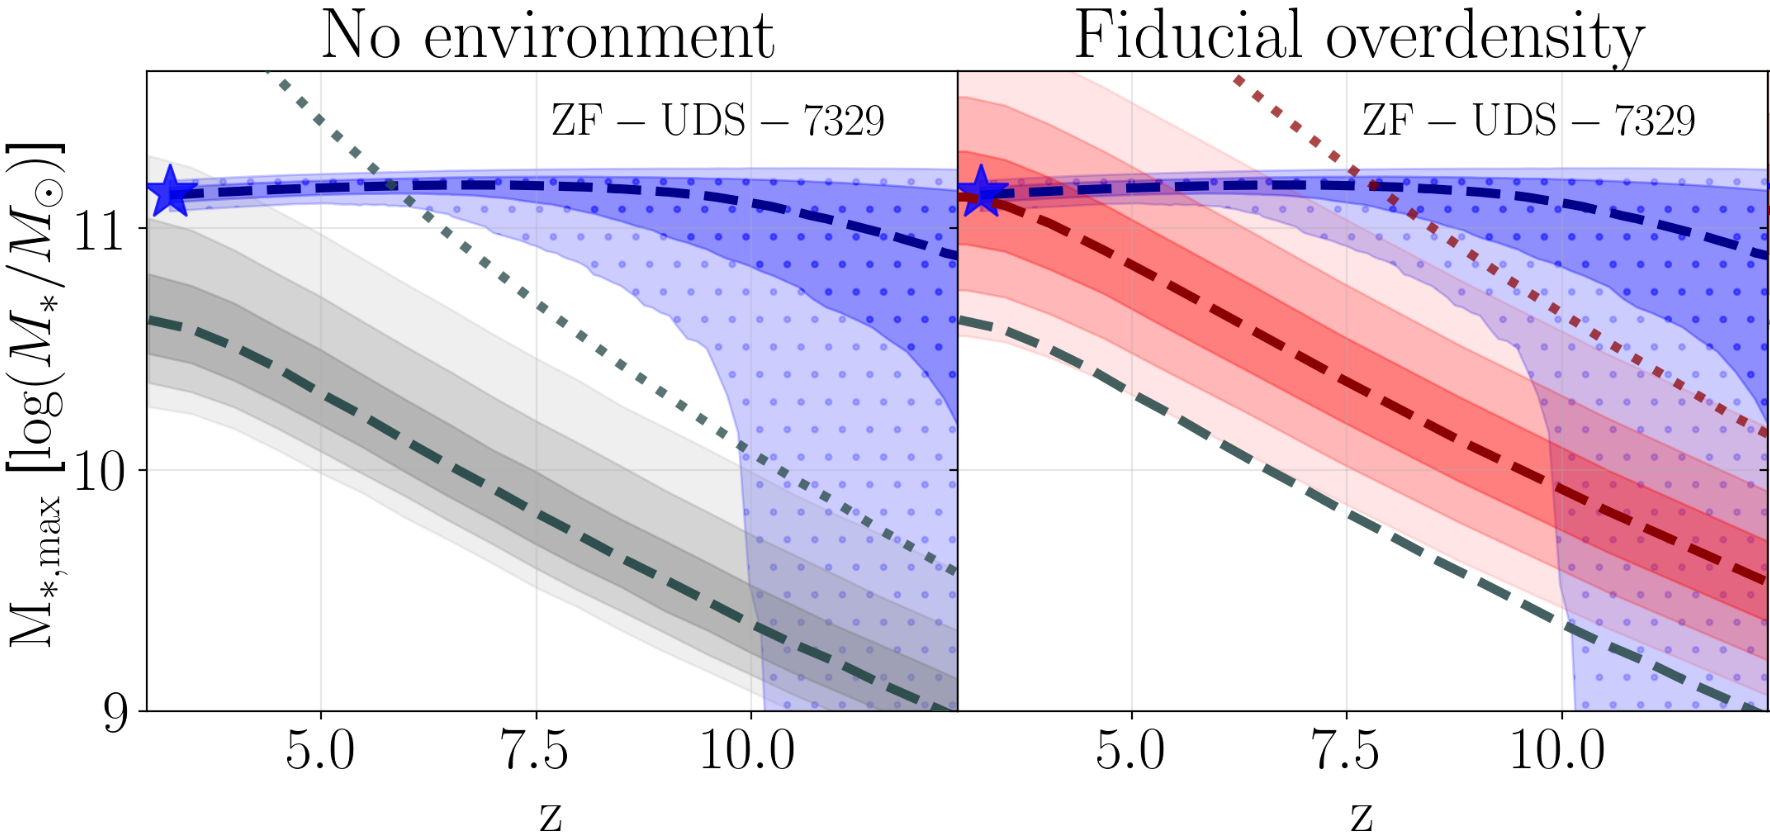
</div>

 <br>

This change, which now much more closely matches the data, reflects some very simple and intuitive:

#### "You should be less surprised to find an extremely massive galaxy if you already knew that it was sitting in the center of a very dense cluster"

Alright, so let's unpack how the code works

## 2. Breaking down the method

So to make this all work, there are four main things that we need to cover!

- [2.1 General Extreme Value Statistics](#2.1-General-Extreme-Value-Statistics)
- [2.2 How the Stellar Mass Function Varies](#2.2-How-the-Stellar-Mass-Function-Varies)
- [2.3 Estimating the Density Percentile of the Densest Region in a Survey](#2.3-Estimating-the-Density-Percentile-of-the-Densest-Region-in-a-Survey)
- [2.4 Convolving EVS Estimates Across Possible Density Percentiles](#2.4-Convolving-EVS-Estimates-Across-Possible-Density-Percentiles)


### 2.1 General Extreme Value Statistics

We briefly summarize the standard EVS setup. Let $ \{X_i\} $ be $ N $ independent and identically distributed random variables drawn from some distribution function. The maximum of the sequence is

$$
X_{\text{max}} = \sup\{X_1, X_2, \dots, X_N\}.
$$

The probability that all values are less than or equal to some $x$ is

$$
\Phi(X_{\text{max}} \leq x; N) = [F(x)]^N.
$$

Where $F(x)$ is the **Cumulative Distribution Function** (CDF). Differentiating gives the **probability density function** (PDF) of the maximum:

$$
\Phi(X_{\text{max}} = x; N) = N f(x) [F(x)]^{N-1},
$$

where $ f(x) = F'(x) $ is the original distribution’s PDF. Note the strength of this simple result! **This holds for any $f(x)$**. 

This is such a remarkable result, both because of its strength and simplicity. Let's try it with a few distributions.


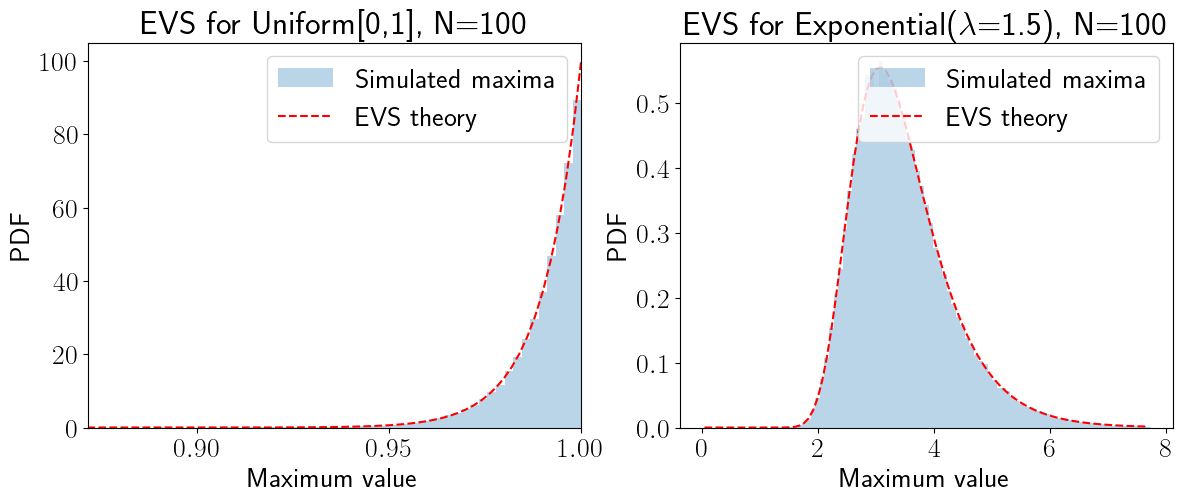

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, expon

plt.rc('text', usetex=True)
import matplotlib as mpl
font = {'size'   : 20}
mpl.rc('font', **font)

# ----- CONFIGURATION -----
N = 100  # number of values in each sample
n_samples = 100000  # number of samples (simulations)

# ----- 1. DEMO FOR UNIFORM DISTRIBUTION -----
uniform_maxima = np.max(np.random.uniform(0, 1, size=(n_samples, N)), axis=1)
u_vals = np.linspace(0, 1, 5*N) #5*N to make sure that we have enough resolution
evs_uniform_pdf = N * u_vals**(N - 1)

# ----- 2. DEMO FOR EXPONENTIAL DISTRIBUTION -----
lambda_exp = 1.5  # rate parameter (lambda > 0)
exp_samples = expon(scale=1/lambda_exp).rvs(size=(n_samples, N))
exp_maxima = np.max(exp_samples, axis=1)

# Empirical histogram for maxima
bins_exp = np.linspace(0, np.percentile(exp_maxima, 99.9), 100)
hist_exp, bins_exp_edges = np.histogram(exp_maxima, bins=bins_exp, density=True)
x_exp = 0.5 * (bins_exp_edges[1:] + bins_exp_edges[:-1])

# Theoretical EVS PDF for exponential:
# F(x) = 1 - exp(-lambda * x), f(x) = lambda * exp(-lambda * x)
F_x = expon.cdf(x_exp, scale=1/lambda_exp)
f_x = expon.pdf(x_exp, scale=1/lambda_exp)
evs_exp_pdf = N * f_x * F_x**(N - 1)

# ----- PLOTTING -----
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Uniform plot
threshold = 1e-4
axs[0].hist(uniform_maxima, bins=50, density=True, alpha=0.3, label="Simulated maxima")
axs[0].plot(u_vals, evs_uniform_pdf, 'r--', label="EVS theory")
axs[0].set(title = f"EVS for Uniform[0,1], N={N}", xlabel = "Maximum value", ylabel = 'PDF', xlim=(u_vals[np.where(evs_uniform_pdf > threshold)[0][0]], 1))
axs[0].legend()

# Exponential plot
axs[1].hist(exp_maxima, bins=bins_exp, density=True, alpha=0.3, label="Simulated maxima")
axs[1].plot(x_exp, evs_exp_pdf, 'r--', label="EVS theory")
axs[1].set(title = r"EVS for Exponential($\lambda$="+f"{lambda_exp}), N={N}", xlabel = "Maximum value", ylabel = 'PDF')
axs[1].legend()

plt.show()


#### That is an amazing match!

Alright, so now we know how to calculate extreme values for a given distribution.

#### Let's now figure out how to model the distribution we care about - starting with the stellar mass function

### 2.2 How the Stellar Mass Function Varies

To estimate the probability of the maximum stellar mass, we now need a **distribution of galaxies by stellar mass**, i.e. the stellar mass function (SMF). To make a theoretical expectation, we can connect it to the theoretically much better understood halo mass function (HMF) and then translate it to stellar mass by assuming a one-to-one relation between galaxy and halo mass:

$$
M_*(z) = f_b \cdot \epsilon_*(z) \cdot M_{\mathrm{halo}},
$$

where $f_b$ is the baryon fraction and $\epsilon_*(z)$ is the stellar baryon fraction/star formation efficiency, which essentially encodes how much of all the possible material that could turn into stars actually turned into stars.

This gives a **mean SMF**, but in the real universe, the SMF varies based on the background density of the universe. This manifests as strong clustering. This means that for a given mass, galaxy count statistics deviate from pure Poisson statistics, and in truth have much higher variance! This excess variance is the **cosmic variance** ($\sigma_{\mathrm{CV}}$) that was introduced in [the introduction](#1.-Introduction-and-Background). Super-Poissonian fluctuation can be modeled by a gamma distribution:

$$
f(x; k, \theta) = \frac{x^{k-1} e^{-x/\theta}}{\theta^k \Gamma(k)},
$$

with the mean $\mu = k \theta$ taken from the mean SMF, and variance set as the total variance of the field

So for each mass in the SMF, we now have a distribution of possible outcomes.

Now, in order to make the full set of SMFs, we have to invoke another fact, which is that number fluctuations for different masses correlate strongly. This arises because it is the **general background density** that mainly drives fluctuations in number densities, and they affect all masses at the same time. That means that if a field is in the 90th percentile in a given mass bin, it will most likely also be in the 90th percentile for all other mass bins. By conditioning on the density percentile $u_{\delta}$, we can therefore build **environment-dependent SMFs** by taking, for each mass bin, the number count at the gamma distribution’s $u_{\delta}$ quantile. This results in a self-consistent set of SMFs varying smoothly with environment. You can see this below!

<div style="text-align: center;">
<img src="graphics/001_smf_clustering.gif" width="800"/>
</div>

 <br>

Since $\sigma_{\mathrm{CV}}$ grows quickly with mass, higher-density environments particularly boost the abundance of massive galaxies (enhancing the SMF’s "knee"), while low-density regions suppress them. This strong coupling between SMF shape, density percentile, and clustering is illustrated dynamically in the gif below, showing how changing clustering strength shifts the set of SMFs.

Now, we can treat each SMF as a probability density function, and use the above technique to get the probability for the most massive galaxy for each density percentile $P(M_{\mathrm{max}}|u_{\delta})$!

Alright, we're halfway there, but now we need to figure out what kind of environment our galaxies are in.

For that, we'll use a little trick. Notice that up until now, we have only talked about environment as a **density percentile**. Well, there is no reason to change that - because estimating the density percentile in a given survey is much easier than our other options.

### 2.3 Estimating the Density Percentile of the Densest Region in a Survey

Our ultra-massive quiescent galaxies are special, they live in the densest regions in the region of space we observed! 
Since direct measurement of overdensity percentiles is generally not possible, we can instead adopt the assumption that the subvolumes containing our galaxies are **the most overdense** of their kind in the survey.

This allows us to estimate the density **percentile**, $u_\delta$ by treating the observed overdensity as the **maximum** among $N_\delta$ statistically similar and independent subvolumes. Because percentiles are uniformly distributed in the interval $[0, 1]$, by definition, the distribution of possible maximum percentile value, $u_{\delta, \mathrm{max}}$, can be computed with EVS! All you need is a good estimate of $N_\delta$, which can naively be estimated as $V_{\mathrm{survey}}/V_{\mathrm{subvolume}}$.


### 2.4 Convolving EVS Estimates Across Possible Density Percentiles

Now, we have the two main ingredients:
- $P(M_\mathrm{max}|{\mathrm{u}_{\delta}})$, the distribution of most massive galaxies for a given density percentile
- $P(\mathrm{u}_{\delta,\mathrm{max}}|\mathrm{N}_{\delta})$, the distribution of maximum density percentiles for a given $N_\delta$

Now, we can convolve these two to give the more useful distribution

\begin{eqnarray}
&& P(M_{\mathrm{max}}\,|\,\mathrm{N}_{\delta}) =   \\
 & &~~~~~~~~~~ \int_0^1 
P(M_\mathrm{max}\,|\,\mathrm{u}_{\delta,\mathrm{max}})\, 
 \cdot P(\mathrm{u}_{\delta,\mathrm{max}}\,|\,\mathrm{N}_{\delta})\, 
d\mathrm{u}_{\delta,\mathrm{max}} \nonumber
\end{eqnarray}

#### The distribution for the mass of the most massive galaxy given that it was found in the most dense of $N_{\delta}$ subvolumes

This is shown graphically below!

<div style="text-align: center;">
<img src="graphics/demo_fig_revised.png" width="1000"/>
</div>

 <br>

#### This is all neatly packaged into just one package down below!

## 3. Putting it all together

We have wrapped all of this into one nice package, `evs_clustering`, that all of you can use! Let's get this under way!

In [5]:
## first, we'll import it
from evs_clustering_fast_new import run_evs_clustering

To run the code, we need to specify three blocks of parameters:
- The dimensions of the survey
- The dimensions of the overdensity that our extreme galaxy inhabits
- Parameters to specify how the calculation should be run

Let's do an example for the ```EXCELS``` survey with one of the overdensities we identified

In [6]:
# Survey geometry parameters
survey_params = {
    'z_min': 3.0,                    # Minimum redshift of the survey volume where the galaxy could have been found
    'z_max': 5.0,                    # Maximum redshift of the survey volume where the galaxy could have been found
    'dRA_survey': 1402 / 3600,       # Survey RA width in degrees
    'dDEC_survey': 844.6 / 3600      # Survey DEC height in degrees
}

# Overdensity parameters
od_params = {
    'z_r': 0.0056,                     # Redshift radius of overdensity
    'z_OD': 4.622,                    # Central redshift of overdensity
    'dDEC_OD': 6 / 3600,           # Declination radius in degrees (converted from arcsec)
    'dRA_OD': 130.6 / 3600,            # RA radius in degrees (converted from arcsec)
    'Ntrials': int(2e7),             # Number of percentiles to compute in the ]0;1[ interval, if unspecified, it will be estimated
    'geometry': 'ellipsoid'          # Geometry of overdensity region, possibilities are "ellipsoid", "cylinder", "rectangle"
}

# General parameters for the run
run_params = {
    'name': 'EXCELS_highz',              # Output name
    'recalculate_cv': False,          # Recompute the cosmic variance, if this is the first time that you're running the code, set as True
    'n_z': 10                        # Number of redshift points to run the calculation at, we'll do 10 for demonstration purposes
}

The ```'recalculate_cv'``` keyword is quite important for the runtime, since it's the calculation of the cosmic variance that takes by far the longest. If you've already run the code once for a given overdensity (so that you have the cosmic variance parameter table), it speeds up the code by a factor of 100-200 to not recalculate the cosmic variance.

Since I have already run the calculation, we can set it to `False`.

If you change the `od_params`, we will have to change it to `True`, and spend a while waiting for the computer to do some complicated numerical integrals.

In [7]:
output_dict = run_evs_clustering(survey_params, od_params, run_params)

The physical volume of the overdensity is 0.09 pMpc³, in comoving units it is 15.29 Mpc³, and the total physical survey volume is 33716.59 pMpc³, in comoving units it is 2157861.57 Mpc³.
The total number of possible subvolumes is: 391796.71, corresponding to a typical outlier degree of 4.56 sigma in gaussian units.
Calculating at the following redshifts
[ 2.86   3.326  3.879  4.541  5.344  6.334  7.571  9.148 11.203 13.949
 17.738]


100%|███████████████████████████████████████████████████████████████| 11/11 [00:29<00:00,  2.65s/it]


Results saved to data/EXCELS_highz_OD_4.622_addsig_0.h5


## Now let's plot it

In [8]:
def plotax(ax, zs, meds, sig1s, sig2s, sig3s = None, xlabel = True, d=0, ylabel = True, c='orange', survey = 'GS-55410 ', ty = 'SED-fitting', filter_size = 0.1, xmin = 3.2, log = False, leg = False, met = '', med_label = False):
    if log:
        meds, sig1s, sig2s = np.log10( meds ), np.log10( sig1s ), np.log10( sig2s )
    if c == 'b' or c == 'royalblue':
        med_color = 'darkblue'
    elif c == 'red':
        med_color = 'darkred'
    elif c =='grey':
        med_color = 'darkslategrey' 
    else:
        med_color = 'k'
    if med_label:
        ax.plot(zs, np.array(meds)-d, c = med_color, linestyle = 'dashed', linewidth=4, label = r'$\mathrm{Median}$', zorder = 10)
    else:
        ax.plot(zs, np.array(meds)-d, c = med_color, linestyle = 'dashed', linewidth=4, zorder = 10)
        
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig1s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig1s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.3, label = r'1$\sigma$'+met)
    
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig2s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig2s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.2, label = r'2$\sigma$'+met)
    if np.any(sig3s):
        ax.fill_between(zs, gaussian_filter1d(np.vstack(sig3s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig3s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.1, label = r'3$\sigma$'+met)
    
    ax.grid(visible = True,alpha=0.3)
    if ty:
        ax.set(title = f'{survey}{ty}', ylim = (9,11.65), xlim = (xmin,12.4))
    else:
        ax.set(ylim = (8,11.8), xlim = (3.2,12.4))
        
    if ylabel:
        # ax.set(ylabel = r'$\mathrm{Stellar~mass}$ [$\mathrm{log}(M_*/M_{\odot})$]')
        ax.set(ylabel = r'$\mathrm{M_{*,max}}$ [$\mathrm{log}(M_*/M_{\odot})$]')

    if xlabel:
        ax.set(xlabel=r'$\mathrm{z}$')

    if leg:
        ax.legend(ncol=2, fontsize = 16, loc = 'lower left', columnspacing=0.5)

    return ax

def compute_conf_intervals(pdf, x, lims = [0.0013498980, 0.0227501319, 0.15865525, 
                                      0.500, 0.8413447, 0.97724986, 0.998650102]):
    """
    Compute confidence intervals for a given pdf
    
    Parameters
    ----------
    x (array): x coordinates
    pdf (array): probability density function evaluated at x
    lims (array): confidence intervals to compute

    Returns
    -------
    CI (array): confidence intervals
    
    """
    
    from scipy import integrate
    norm = integrate.trapz(pdf, x)
    intcum = integrate.cumtrapz(pdf/norm.reshape(-1,1), x, initial=0.)
    if np.squeeze(pdf).ndim > 1:
        CI = []
        for ic in intcum:
            CIz = []
            for lim in lims:
                CIz.append(x[np.argmin(np.abs(ic-lim))])
            CI.append(CIz)
    else:
        CI = x[[np.max(np.where(intcum < lim)) for lim in lims]]
        
    return intcum, np.vstack(CI)


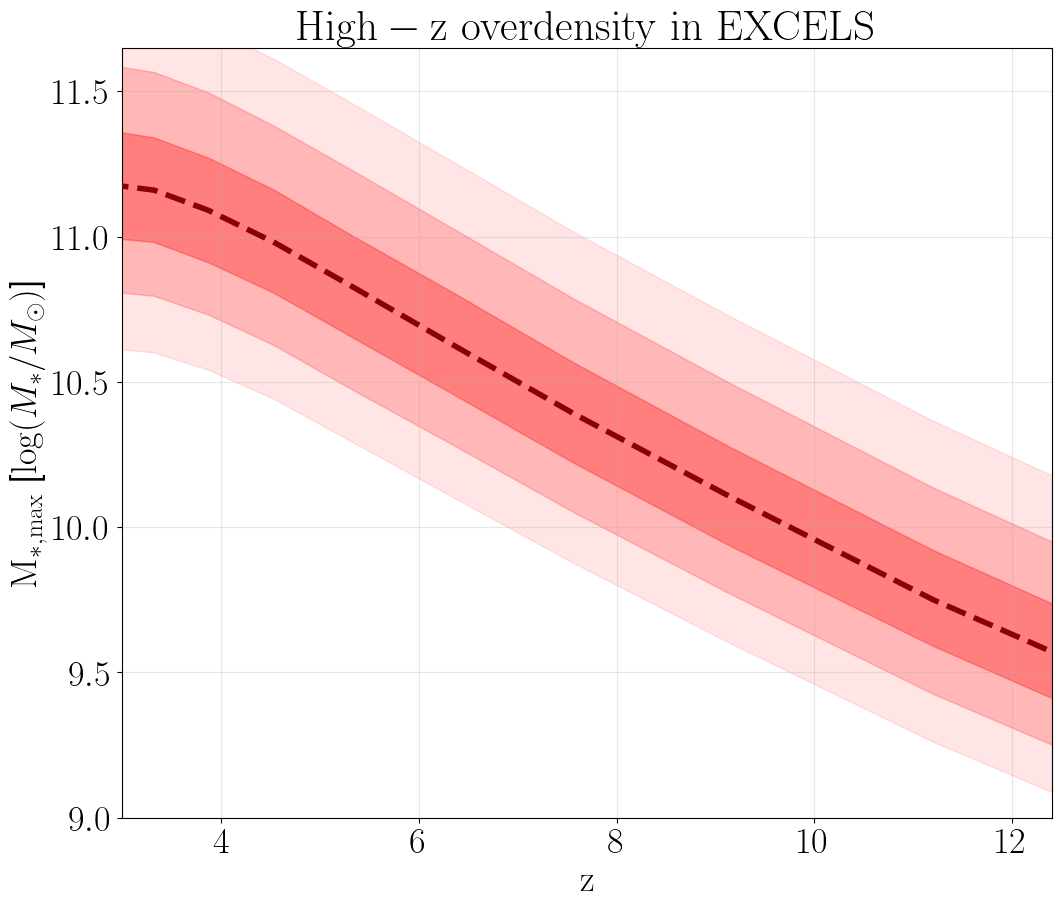

In [9]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.ndimage import gaussian_filter1d

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 10))

font = {'size'   : 26}
mpl.rc('font', **font)

dat = np.loadtxt('dfs/second_gal.csv')
plotax(ax, z_AC, df['m2'], np.vstack([df['m3'], df['m1']]).T, np.vstack([df['m0'], df['m4']]).T, ylabel = False, log = True, c = c_SED, xmin = np.min(z_AC)/fdiv, survey = title_names[idx], met = SEDlabel, med_label = True , hatch = hatch_SED )

c = 'red'

lw1 = 4
alpha1 = 0.8
d = 0.0
title = r'$\mathrm{High-z~overdensity~in~EXCELS}$'

with h5py.File(f'../evstats/data/EXCELS_highz_OD_4.622_addsig_0.h5','r') as hf: 
    log10m = hf['log10m'][:]
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
zs = z
meds_cdf = CIs[:,3]
sig1s = np.vstack([CIs[:,2], CIs[:,4]]).T
sig2s = np.vstack([CIs[:,1], CIs[:,5]]).T
sig3s = np.vstack([CIs[:,0], CIs[:,6]]).T


ax = plotax(ax, zs, meds_cdf, sig1s, sig2s, sig3s = sig3s, d = d, ylabel = True, survey = title, ty = ' ', c = c, xmin = 3, met = r' $\mathrm{M_{*,\mathrm{max}}~(Environment)}$')

FileNotFoundError: dfs/second_gal.csv not found.